# Исследование сервиса Яндекс Афиша

## Цель и задачи  

**Цель:** Провести исследовательский анализ данных заказов и пользователей в сервися "Яндекс Афиша"

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - Изучить данные более детально;
    - Изучить взаимосвязь данных;
    - Сформировать профиль пользователя, выделив признаки и факторы, которые могут влиять на повторные заказы;
    - Выяснить, как распределены данные и какие закономерности в них наблюдаются;
    - Провести корреляционный анализ и вычислить коэффициенты phik, чтобы узнать, какие признаки влияют на количество заказов.
4. Сформулировать выводы по проведённому анализу, с целью рекомеендаии для бизнес. Нужно понять,  какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:
    - Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
    - Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
    - Оптимизировать маркетинговые бюджеты.
    - Повысить общий уровень удержания клиентов.


## Данные

Для анализа поступили данные о заказах сервиса "Яндекс Афиша" за определенный период.


### Описание данных

* user_id — уникальный идентификатор пользователя, совершившего заказ;
* device_type_canonical — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
* order_id — уникальный идентификатор заказа;
* order_dt — дата создания заказа (используйте данные created_dt_msk );
* order_ts — дата и время создания заказа (используйте данные created_ts_msk );
* currency_code — валюта оплаты;
* revenue — выручка от заказа;
* tickets_count — количество купленных билетов;
* days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
* event_id — уникальный идентификатор мероприятия;
* service_name — название билетного оператора;
* event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее);
* region_name — название региона, в котором прошло мероприятие;
* city_name — название города, в котором прошло мероприятие.

## Структура проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных.
3. Создание профиля пользователя
4. Исследовательский анализ данных.
5. Итоговые выводы и рекомендации.

---

## Установка недостающих библиотек, загрузка необходимых библеотек.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# phik
!pip install phik
from phik import phik_matrix
# sqlalchemy
!pip install sqlalchemy 
from sqlalchemy import create_engine 
# psycopg2
!pip install psycopg2-binary
# python-dotenv 
!pip install python-dotenv
# from urllib.parse import quote_plus
import os
from dotenv import load_dotenv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [101]:
# !pip freeze > requirements.txt

In [102]:
# import sys
# !{sys.executable} -m pip freeze > requirements.txt

## 1. Загрузка данных и знакомство с ними

In [5]:
load_dotenv()
db_config = {'user': os.getenv('DB_USER'), # имя пользователя
             'pwd': os.getenv('DB_PASSWORD'), # пароль
             'host': os.getenv('DB_HOST'),
             'port': os.getenv('DB_PORT'), # порт подключения
             'db': os.getenv('DB_NAME') # название базы данных
             } 

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [7]:
engine = create_engine(connection_string) 

In [8]:
query = '''
SELECT
	user_id,
	device_type_canonical,
	order_id,
	created_dt_msk order_dt,
	created_ts_msk order_ts,
	currency_code,
	revenue,
	tickets_count,
	date_part ('day', created_dt_msk - LAG (created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk)) AS days_since_prev,
	event_id,
	event_name_code event_name,
	service_name,
	event_type_main,
	region_name,
	city_name
FROM afisha.events e
JOIN afisha.purchases p USING (event_id)
JOIN afisha.city c using(city_id)
JOIN afisha.regions r using(region_id)
WHERE (p.device_type_canonical = 'mobile' OR p.device_type_canonical = 'desktop') AND (e.event_type_description != 'фильм')
ORDER BY user_id
'''

In [9]:
df = pd.read_sql_query(query, con=engine)
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,Весь в билетах,другое,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,Весь в билетах,другое,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,Прачечная,театр,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,Билеты без проблем,стендап,Широковская область,Ягодиновка


### Изучить df

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

In [11]:
# Импортируем датасет с курсом валют
tenge = pd.read_csv(r'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
# Загрузим датасет с курсами валют, для дальнейшей конвертации валюты.
tenge = pd.read_csv(r'C:\Users\frezc\pyproject\final_tickets_tenge_df.csv')
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [13]:
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


### Промежуточный вывод: 
Датасет df содержит 15 столбцов и 290611 строк, в которых приведены данные о покупках билетов на мероприятия через сервис "Яндекс Афиша"

- Названия столбцов приведены к одному виду, типа snake case;
- user_id, event_name, service_name, event_type_name, region_name, city_name - содержат текстовые данные и имеют тип object
- device_type_cannonical, currency_code - категориальные данные с типом object
- Числовые данные хранятся в типах данных int64 и float64
- tickets_count возможно, можно оптимизировать.
- days_since_prev - должен содержать только целочисленные значения, можно опитимизировать
- Колонки с датой и ременем хранятся в типах datetime64 [ns]
- Пропуски содержатся только в столбце days_since_prev

Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

--------------------------------------------------------------------------------

Датасет tenge содержит информацию о курсе тенге по дням за 2024 год

- Колонка data имеет тип object

Судя по первому знакомству с данными, нужно будет ее изменить на тип datetime

In [14]:
# создаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
temp = df.copy()
if len(temp)==len(df):
    print(f'Исходный и скопированный df равны и имеют длинну {len(temp)} строк')
else:
    print('Проверьте данные')

Исходный и скопированный df равны и имеют длинну 290611 строк


## 2. Предобработка данных

### 2.1 Конвертировать валюту

In [15]:
tenge['data'] = pd.to_datetime(tenge['data'])
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [16]:
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [17]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк


In [18]:
df_full = df.merge(tenge, left_on='order_dt', right_on='data', how='left')
df_full.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt


In [19]:
df_full['revenue_rub'] = df_full['revenue']

mask = df_full['currency_code'].str.lower() == 'kzt'
df_full.loc[mask, 'revenue_rub'] = round(df_full.loc[mask, 'revenue'] * df_full.loc[mask, 'curs'] / 100, 2)


In [20]:
# проверим
df_full[df_full['currency_code']=='kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,data,nominal,curs,cdx,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,Билеты без проблем,другое,Верхоречная область,Серебрянка,2024-09-17,100,19.0125,kzt,98.50
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,Билеты без проблем,другое,Верхоречная область,Серебрянка,2024-09-02,100,18.9330,kzt,65.73
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,Билеты без проблем,другое,Верхоречная область,Серебрянка,2024-09-09,100,18.5991,kzt,61.15
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,Мой билет,концерты,Верхоречная область,Серебрянка,2024-06-11,100,19.8928,kzt,4380.70
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,Мой билет,концерты,Шанырский регион,Широковка,2024-06-04,100,19.9833,kzt,1478.30


In [21]:
# Убираем лишние столбцы.
cols_to_drop = ['data', 'nominal', 'curs', 'cdx']
df_rub = df_full.drop(columns=cols_to_drop)

In [22]:
df_rub.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


### Промежуточный вывод
Добавлена колонка `revenue_rub`, содержащая выручку только в рублях (тенге переведны в рубль)

### 2.2 Пропуски / Типы данных / Ошибки в данных / Дубликаты

#### Пропуски

In [23]:
df_rub.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [24]:
def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean()
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    # Форматируем при выводе через Styler
    return (missing_stats.style.format({'Доля пропусков': '{:.4f}'}).background_gradient(cmap='coolwarm'))
show_missing_stats(df_rub)

,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.0755


Пропуски содержатся только в колонке days_since_prev. Это нормально, тк есть пользователи, которые не совершали более 1 покупки.

#### Типы данных

In [25]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

- user_id - OK
- device_type_canonical - OK
- order_id - OK
- order_dt - Возможно изменить на date, но не будем, удобнее для дальнейшей работы.
- order_ts - ОК
- currency_code - ОК
- revenue - ОК
- tickets_count - Оптимизировать, снизить разрядность
- days_since_prev - Оптимизировать, снизить разрядность
- event_id - ОК
- event_name - ОК
- service_name - ОК
- event_type_main - ОК
- region_name - ОК
- city_name - ОК
- revenue_rub - OK   

In [26]:
for column in df_rub [['tickets_count','days_since_prev']]:
    df_rub[column] = pd.to_numeric(df_rub[column], downcast='integer')

In [27]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

Колонка days_in_prev разрядность не понижена из-за наличия пропусков.

In [28]:
df_rub['days_since_prev'] = df_rub['days_since_prev'].astype('Int16')

In [29]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  Int16         
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

типы данных приведены к нужным форматам.

#### Ошибки  в данных

In [30]:
1# Проверяем уникальные значения в категориальных колонках 
for column in ['device_type_canonical', 'currency_code', 'event_type_main']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']



In [31]:
df_rub[df_rub['event_type_main']=='другое']

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,<NA>,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,8.49
26,001e7037d013f0f,mobile,1673330,2024-07-04,2024-07-04 08:06:44,rub,479.54,2,<NA>,83717,0f8e05fc-56be-4bc7-b775-e3cd61ae6fe4,Мой билет,другое,Златопольский округ,Кумсай,479.54
38,002b75ca606ba46,mobile,3020960,2024-10-02,2024-10-02 16:05:45,rub,203.30,3,63,573041,c1f637f3-f9e5-4026-a465-f500102213ea,Мой билет,другое,Каменевский регион,Глиногорск,203.30
39,002b75ca606ba46,desktop,3020989,2024-10-02,2024-10-02 13:54:33,rub,271.07,4,0,573041,c1f637f3-f9e5-4026-a465-f500102213ea,Мой билет,другое,Каменевский регион,Глиногорск,271.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290597,fffcd3dde79eb2c,mobile,8019371,2024-09-12,2024-09-12 14:47:03,rub,31.58,3,0,384441,108c5bfa-b11e-47ac-a482-d0e76702508e,Лови билет!,другое,Североярская область,Озёрск,31.58
290604,fffcd3dde79eb2c,mobile,4326395,2024-10-26,2024-10-26 17:43:23,rub,414.12,4,4,571114,67173a55-dd4c-4f71-ba3a-adacd47464f4,Билеты без проблем,другое,Каменевский регион,Глиногорск,414.12
290605,fffcd3dde79eb2c,mobile,368620,2024-10-27,2024-10-27 18:00:57,rub,965.57,4,1,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,Весь в билетах,другое,Каменевский регион,Глиногорск,965.57
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,Весь в билетах,другое,Каменевский регион,Глиногорск,1448.36


В категориальных данных аномалий не обнаружено

In [32]:
#распределение численных данных
df_rub['revenue_rub'].describe()

count    290611.000000
mean        555.571989
std         875.498170
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

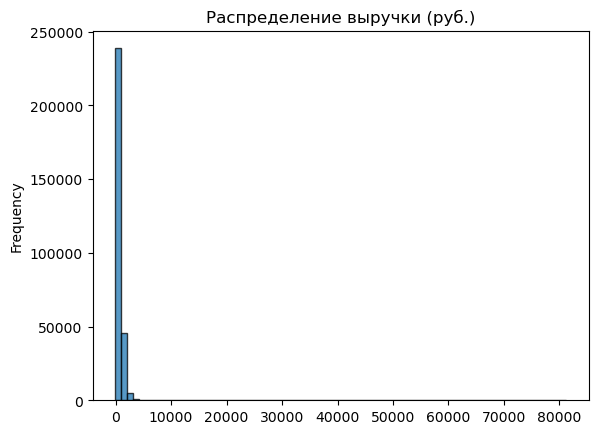

In [33]:
df_rub['revenue_rub'].plot(kind='hist',
                           bins=75,
                           alpha=0.75,
                          edgecolor='black',
                          rot=0)

plt.title('Распределение выручки (руб.)')

plt.show()

Видим, что основная часть значений не превышает 5000 руб, предположительно в данных ест выбросы, которые будут мешать дальнейшему анализу. А также, в данных есть отрицательные значения, чего быть не должно.

In [34]:
print(f"Отрицательных значений в данных к удалению: {len(df_rub[df_rub['revenue_rub']<0])}")
print(f"Ввыбросов в данных к удалению: {len(df_rub[df_rub['revenue_rub'] > df_rub['revenue_rub'].quantile(0.99)])}")

Отрицательных значений в данных к удалению: 381
Ввыбросов в данных к удалению: 2825


In [35]:
df_rub_f = df_rub[(df_rub['revenue_rub'] <= df_rub['revenue_rub'].quantile(0.99)) & (df_rub['revenue_rub'] >=0)]
df_rub_f['revenue_rub'].describe()

count    287405.000000
mean        518.719259
std         511.951843
min           0.000000
25%         112.600000
50%         344.830000
75%         788.900000
max        2628.420000
Name: revenue_rub, dtype: float64

Колонка revenue_rub нормализирована

In [36]:
# Колонка tickets_count
df_rub_f['tickets_count'].describe()

count    287405.000000
mean          2.741323
std           1.163087
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

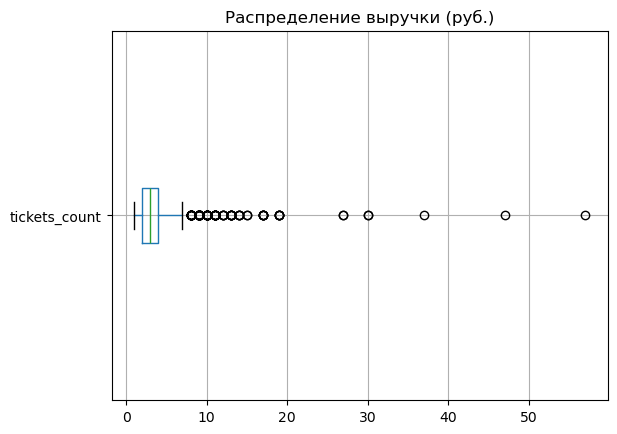

In [37]:
df_rub.boxplot(column='tickets_count', vert=False)

plt.title('Распределение выручки (руб.)')

plt.show()

В колонке tickets_count есть значения (57) сильно превышающие средние (2,74), но фильтровать их не станем, тк не исключены покупки билетов для групп школьников или кооперативов.

In [38]:
# Проверим сколько удалено строк датасета
a, b = len(temp), len(df_rub_f)
print(" Было строк в исходном датасете", a,
      '\n', "Осталось строк в датасете после обработки", b,
      '\n', "Удалено строк в датасете после обработки", a-b,
      '\n', "Процент потерь", round((a-b)/a*100, 2))

 Было строк в исходном датасете 290611 
 Осталось строк в датасете после обработки 287405 
 Удалено строк в датасете после обработки 3206 
 Процент потерь 1.1


#### Дубликаты

In [39]:
# Проверяем полные дубликаты в датасете
print(f'Полных явных дубликатов в данных: {df_rub_f.duplicated().sum()}')

Полных явных дубликатов в данных: 0


In [40]:
print(f'Дублированных заказов: {df_rub_f.duplicated(subset='order_id').sum()}')

Дублированных заказов: 0


### Промежуточные выводы (Предобработка данных)

В результате предобработки данных были выполнены следующие действия:

- Добавлена колонка `revenue_rub`, в которой выручка приведена к единой валюте.
- Пропуски: в данных есть органические пропуски в колонке `days_since_prev`, которые означают, что пользователь не делал покупки ранее. Оставляем без изменений.
- Типы данных нормализованы, колонки `tickets_count`, `days_since_prev` - понижена разрялность.
- Всего отфильтровано 3206 строк, что составляет 1,1% от всех данных (отфильтрованы строки с отрицательной выручкой, Отфильтровали выбросы выше 99 процентиля по колонке `revenue_rub`)
- Дубликатов не обнаружено

---


## 3. Создание профиля пользователя

#### 3.1 Построить профиль пользователя

In [41]:
df_user = df_rub_f.sort_values(['user_id', 'order_id']).groupby('user_id').agg(
    first_date=('order_dt', 'min'),
    last_date=('order_dt', 'max'),
    device_first=('device_type_canonical', 'first'),
    region_first=('region_name', 'first'),
    service_first=('service_name', 'first'),
    genre_first=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_rev=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_below=('days_since_prev', 'mean')
    ).reset_index()
df_user.head()

,user_id,first_date,last_date,device_first,region_first,service_first,genre_first,total_orders,avg_rev,avg_tickets,avg_days_below
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,За билетом!,другое,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,mobile,Озернинский край,Билеты без проблем,стендап,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0


In [42]:
def create_is_two(x):
    if x >= 2:
        return 1
    return 0

In [43]:
df_user['is_two'] = df_user['total_orders'].apply(create_is_two)

In [44]:
def create_is_five(x):
    if x >= 5:
        return 1
    return 0

In [45]:
df_user['is_five'] = df_user['total_orders'].apply(create_is_five)

In [46]:
df_user[df_user['is_five']==1].head()

,user_id,first_date,last_date,device_first,region_first,service_first,genre_first,total_orders,avg_rev,avg_tickets,avg_days_below,is_two,is_five
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
13,002b75ca606ba46,2024-07-08,2024-10-16,mobile,Каменевский регион,Мой билет,другое,6,443.580000,3.000000,20.0,1,1
15,002ec276eee9b0b,2024-07-10,2024-10-31,mobile,Каменевский регион,Билеты без проблем,другое,22,811.942727,2.863636,5.380952,1,1
16,0033403583a55ed,2024-06-19,2024-09-17,mobile,Лесодальний край,Край билетов,театр,6,135.691667,1.666667,18.0,1,1
18,00345f897f95a34,2024-06-02,2024-10-23,mobile,Каменевский регион,Край билетов,театр,8,1338.258750,2.875000,20.428571,1,1


In [47]:
len(df_user[df_user['is_two']==0])

8363

Построен датасет с профилем пользователя, добавлены 2 бинарные колонки, которые гвоорят о количестве заказов пользователя. (is_two - 2 и больше заказа, is_five - 5 и более заказов). Всего в данных 21838 пользователей.

#### 3.2 Анализ данных и статистика

In [48]:
print(f'Общее число пользователей в выборке: {df_user['user_id'].count()}')
print(f'Средняя выручка одного заказа: {round(df_rub_f['revenue_rub'].sum() / df_user['total_orders'].sum(), 2)} руб.')
print(f'Доля пользователей, совершивших 2 и более заказа: {round(100*df_user['user_id'][df_user['is_two']==1].count() / df_user['user_id'].count(), 2)}%')
print(f'Доля пользователей, совершивших 5 и более заказов: {round(100*df_user['user_id'][df_user['is_five']==1].count() / df_user['user_id'].count(), 2)}%')

Общее число пользователей в выборке: 21838
Средняя выручка одного заказа: 518.72 руб.
Доля пользователей, совершивших 2 и более заказа: 61.7%
Доля пользователей, совершивших 5 и более заказов: 29.0%


In [49]:
df_user['total_orders'].describe()

count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64

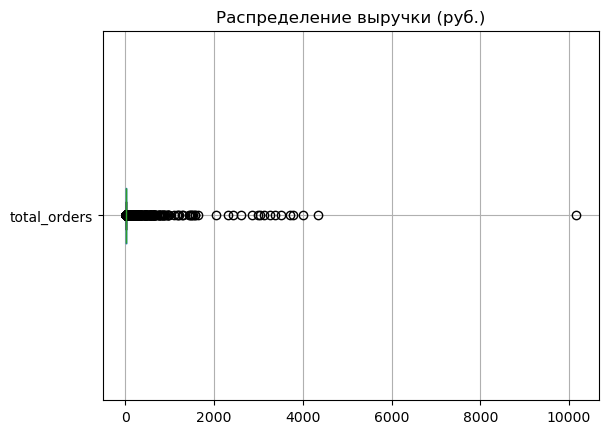

In [50]:
df_user.boxplot(column='total_orders', vert=False)

plt.title('Распределение выручки (руб.)')

plt.show()

По количеству заказов, все данные скопились в первой сотне, что подтверждает среднее. Однако максимальное значение сильно искажает действительность. Это выброс.

In [51]:
df_user['avg_tickets'].describe()

count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets, dtype: float64

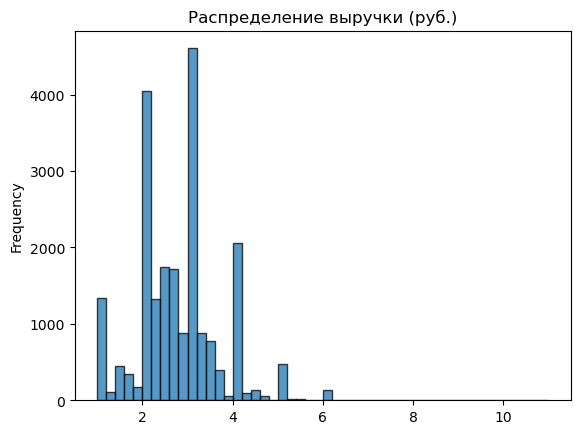

In [52]:
df_user['avg_tickets'].plot(kind='hist',
                           bins=50,
                           alpha=0.75,
                          edgecolor='black',
                          rot=0)

plt.title('Распределение выручки (руб.)')

plt.show()

В числе билетов Аномалий не обнаружено

In [53]:
df_user['avg_days_below'].describe()

count      13504.0
mean     15.864348
std      22.330357
min            0.0
25%            1.0
50%            8.0
75%           20.5
max          148.0
Name: avg_days_below, dtype: Float64

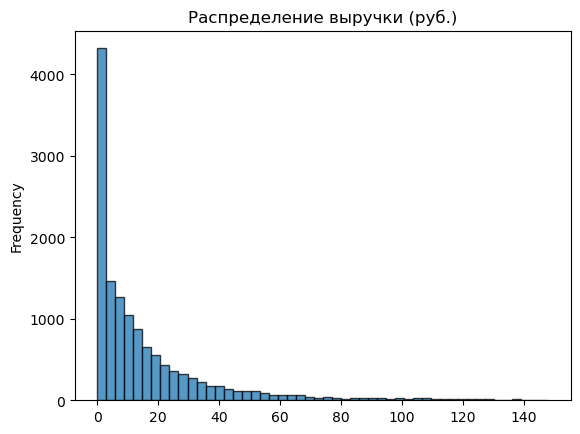

In [54]:
df_user['avg_days_below'].plot(kind='hist',
                           bins=50,
                           alpha=0.75,
                          edgecolor='black',
                          rot=0)

plt.title('Распределение выручки (руб.)')

plt.show()

распределение в колонке "Дней между покупками" - аномалий не обнаруно.

In [55]:
q95 = df_user['total_orders'].quantile(0.95)
q99 = df_user['total_orders'].quantile(0.99)

print(f"95-й квартиль: {q95}")
print(f"99-й квартиль: {q99}")


95-й квартиль: 31.0
99-й квартиль: 152.0


In [56]:
num_above_95 = (df_user['total_orders'] > q95).sum()
num_above_99 = (df_user['total_orders'] > q99).sum()

print(f"Количество заказов выше 95-го квартиля: {num_above_95}, что составляет {round(num_above_95 / df_user['total_orders'].count()*100,2 )}%")
print(f"Количество заказов выше 99-го квартиля: {num_above_99}, что составляет {round(num_above_99/df_user['total_orders'].count()*100, 2)}%")

Количество заказов выше 95-го квартиля: 1091, что составляет 5.0%
Количество заказов выше 99-го квартиля: 216, что составляет 0.99%


- Отфильтровать значения выше 99 перцентиля, это не исказит общую картину. 
- 5% данных лежит выше отметки 95-го процентиля. Это значительная часть данных.

In [57]:
#df_rub_f = df_rub[(df_rub['revenue_rub'] <= df_rub['revenue_rub'].quantile(0.99)) & (df_rub['revenue_rub'] >=0)]

df_eda = df_user[df_user['total_orders']<=df_user['total_orders'].quantile(0.99)]

In [58]:
df_eda['total_orders'].describe()

count    21622.000000
mean         6.496624
std         14.310784
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

In [59]:
# Проверим сколько удалено строк датасета
a, b = len(df_user), len(df_eda)
print(" Было строк в исходном датасете", a,
      '\n', "Осталось строк в датасете после обработки", b,
      '\n', "Удалено строк в датасете после обработки", a-b,
      '\n', "Процент потерь", round((a-b)/a*100, 2))

 Было строк в исходном датасете 21838 
 Осталось строк в датасете после обработки 21622 
 Удалено строк в датасете после обработки 216 
 Процент потерь 0.99


### Промежуточные выводы (Профиль пользователя)

В результате составления профиля пользователя, была создана таблица,  воторой содержит колонки: 
```
- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле event_type_main );
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.
```

- Отфильтрованы значения по общему количеству заказов, процент потерь составляет: 0,99%

Данные нормализованы и готовы к Исследовательскому анализу.

---


## 4. Исследовательский анализ данных


### Задача 4.1.1. Изучите распределение пользователей по признакам.
- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

In [60]:
df_eda.head()

,user_id,first_date,last_date,device_first,region_first,service_first,genre_first,total_orders,avg_rev,avg_tickets,avg_days_below,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,За билетом!,другое,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Озернинский край,Билеты без проблем,стендап,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


In [61]:
#Кол-во пользователей по типу их первого мероприятия
df_first_type = df_eda.groupby('genre_first').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False).reset_index()
df_first_type['share'] = round(df_first_type['users_count'] / df_first_type['users_count'].sum() * 100, 2)
df_first_type

,genre_first,users_count,share
0,концерты,9304,43.03
1,другое,5271,24.38
2,театр,4476,20.70
3,стендап,1106,5.12
4,спорт,945,4.37
5,выставки,392,1.81
6,ёлки,128,0.59


In [62]:
#Кол-во пользователей по типу устройства пр ипервой покупке
df_first_device = df_eda.groupby('device_first').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False).reset_index()
df_first_device['share'] = round(df_first_device['users_count'] / df_first_device['users_count'].sum() * 100, 2)
df_first_device

,device_first,users_count,share
0,mobile,18045,83.46
1,desktop,3577,16.54


In [63]:
#Кол-во пользователей по региону проведения мероприятия из 1го заказа
df_first_region = df_eda.groupby('region_first').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False).reset_index()
df_first_region['share'] = round(df_first_region['users_count'] / df_first_region['users_count'].sum() * 100, 2)
df_first_region=df_first_region.head(10)
df_first_region

,region_first,users_count,share
0,Каменевский регион,6905,31.94
1,Североярская область,3494,16.16
2,Широковская область,1230,5.69
3,Озернинский край,770,3.56
4,Малиновоярский округ,560,2.59
5,Светополянский округ,490,2.27
6,Травяная область,441,2.04
7,Речиновская область,438,2.03
8,Яблоневская область,436,2.02
9,Медовская область,434,2.01


In [64]:
#Кол-во пользователей по билетному оператору при первом заказе
df_first_service = df_eda.groupby('service_first').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False).reset_index()
df_first_service['share'] = round(df_first_service['users_count'] / df_first_service['users_count'].sum() * 100, 2)
df_first_service=df_first_service.head(10)
df_first_service

,service_first,users_count,share
0,Билеты без проблем,4989,23.07
1,Лови билет!,2909,13.45
2,Мой билет,2864,13.25
3,Билеты в руки,2494,11.53
4,Облачко,2255,10.43
5,Лучшие билеты,1276,5.90
6,Весь в билетах,1261,5.83
7,Прачечная,607,2.81
8,Край билетов,443,2.05
9,Яблоко,376,1.74


- 43% пользователей покупают билеты на концерты, это самый популярный вид мероприятий на платформе;
- 83% пользователей делают покупки с мобильных устройств;
- Более 32% пользователей, впервые делали заказ в Каменевском регионе, 18% в Североярской области;
- 23% пользователей делали заказ через оператора "Билет без проблем".
  
Таким образом, мы отметили "точки входа": мобильное устройство, "билет без проблем", концерт в Каменевском регионе.

### Задача 4.1.2. Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
-Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

In [65]:
# Сгруппируем по жанру и найдем кол-во пользователей общее и со вторыми покупками. Посчитаем долю.
df_first_type_is_two = df_eda.groupby('genre_first').agg(
    users_count=('user_id', 'count'),
    is_two_count=('is_two', 'sum')
    ).sort_values('users_count', ascending=False).reset_index()
df_first_type_is_two['is_two_share'] = round(df_first_type_is_two['is_two_count'] / df_first_type_is_two['users_count'] * 100, 2)
df_first_type_is_two

,genre_first,users_count,is_two_count,is_two_share
0,концерты,9304,5652,60.75
1,другое,5271,3087,58.57
2,театр,4476,2924,65.33
3,стендап,1106,672,60.76
4,спорт,945,594,62.86
5,выставки,392,244,62.24
6,ёлки,128,86,67.19


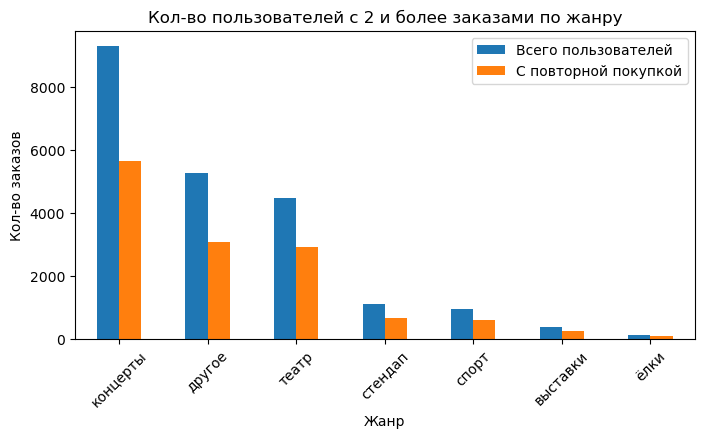

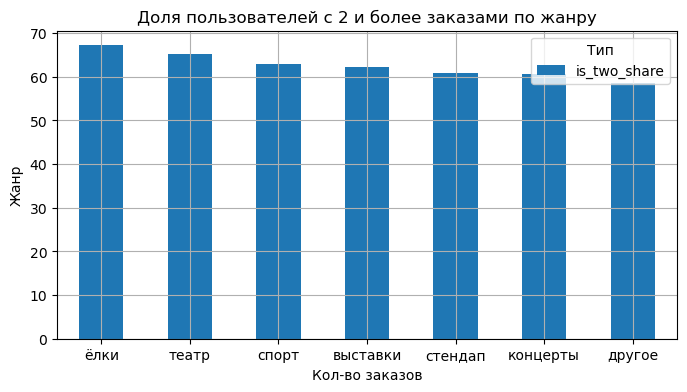

In [66]:
df_first_type_is_two[['genre_first', 'users_count', 'is_two_count']].plot(kind='bar',
                x='genre_first', y=['users_count', 'is_two_count'],
                title=f'Кол-во пользователей с 2 и более заказами по жанру',
                legend=True,
                ylabel='Кол-во заказов',
                xlabel='Жанр',
                label=['Всего пользователей', 'С повторной покупкой'],
                rot=45,
                figsize=(8, 4))
df_first_type_is_two[['genre_first', 'is_two_share']].sort_values('is_two_share', ascending=False).plot(kind='bar',
                title=f'Доля пользователей с 2 и более заказами по жанру',
                x='genre_first',
                legend=True,
                ylabel='Жанр',
                xlabel='Кол-во заказов',
                rot=0,
                figsize=(8, 4))
plt.grid()
plt.legend(title='Тип')

plt.show()

In [67]:
# Сгруппируем по типу устройства и найдем долю пользователей со второй покупкой
df_first_device_is_two = df_eda.groupby('device_first').agg(
    users_count=('user_id', 'count'),
    is_two_count=('is_two', 'sum')
    ).sort_values('users_count', ascending=False).reset_index()
df_first_device_is_two['is_two_share'] = round(df_first_device_is_two['is_two_count'] / df_first_device_is_two['users_count'] * 100, 2)
df_first_device_is_two

,device_first,users_count,is_two_count,is_two_share
0,mobile,18045,11026,61.10
1,desktop,3577,2233,62.43


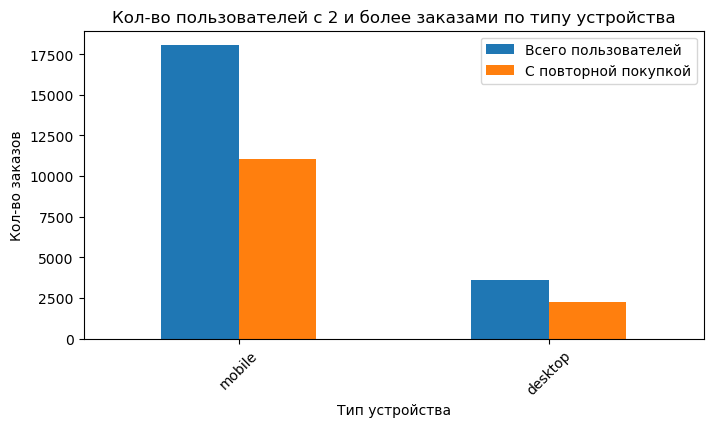

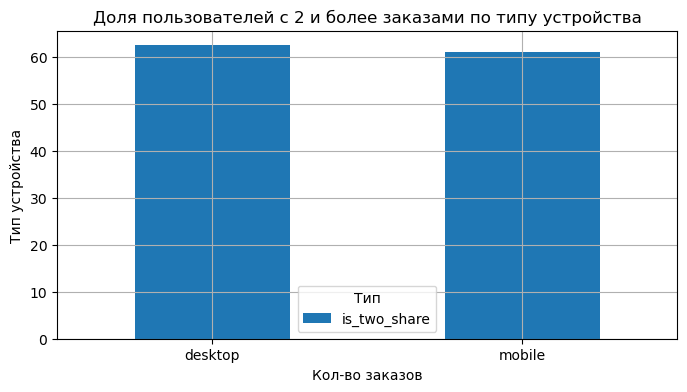

In [68]:
df_first_device_is_two[['device_first', 'users_count', 'is_two_count']].plot(kind='bar',
                x='device_first', y=['users_count', 'is_two_count'],
                title=f'Кол-во пользователей с 2 и более заказами по типу устройства',
                legend=True,
                ylabel='Кол-во заказов',
                xlabel='Тип устройства',
                label=['Всего пользователей', 'С повторной покупкой'],
                rot=45,
                figsize=(8, 4))
df_first_device_is_two[['device_first', 'is_two_share']].sort_values('is_two_share', ascending=False).plot(kind='bar',
                title=f'Доля пользователей с 2 и более заказами по типу устройства',
                x='device_first',
                legend=True,
                ylabel='Тип устройства',
                xlabel='Кол-во заказов',
                rot=0,
                figsize=(8, 4))
plt.grid()
plt.legend(title='Тип')

plt.show()

In [69]:
# Сгруппируем по региону и найдем долю пользователей со второй покупкой
df_first_region_is_two = df_eda.groupby('region_first').agg(
    users_count=('user_id', 'count'),
    is_two_count=('is_two', 'sum')
    ).sort_values('users_count', ascending=False).reset_index()
df_first_region_is_two['is_two_share'] = round(df_first_region_is_two['is_two_count'] / df_first_region_is_two['users_count'] * 100, 2)
df_first_region_is_two=df_first_region_is_two.head(10)
df_first_region_is_two

,region_first,users_count,is_two_count,is_two_share
0,Каменевский регион,6905,4240,61.40
1,Североярская область,3494,2131,60.99
2,Широковская область,1230,795,64.63
3,Озернинский край,770,468,60.78
4,Малиновоярский округ,560,328,58.57
5,Светополянский округ,490,333,67.96
6,Травяная область,441,253,57.37
7,Речиновская область,438,277,63.24
8,Яблоневская область,436,269,61.70
9,Медовская область,434,282,64.98


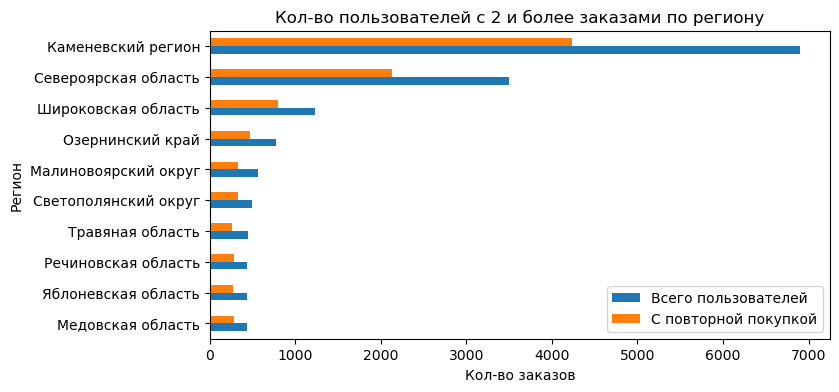

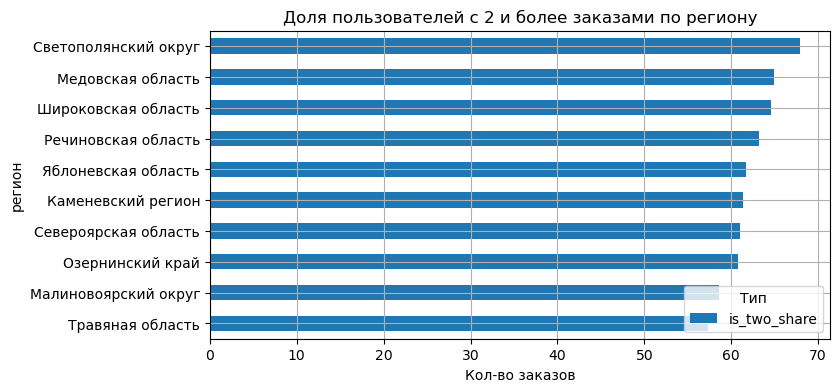

In [70]:
df_first_region_is_two[['region_first', 'users_count', 'is_two_count']].sort_values('users_count').plot(kind='barh',
                x='region_first', y=['users_count', 'is_two_count'],
                title=f'Кол-во пользователей с 2 и более заказами по региону',
                legend=True,
                ylabel='Регион',
                xlabel='Кол-во заказов',
                label=['Всего пользователей', 'С повторной покупкой'],
                rot=0,
                figsize=(8, 4))
df_first_region_is_two[['region_first', 'is_two_share']].sort_values('is_two_share').plot(kind='barh',
                title=f'Доля пользователей с 2 и более заказами по региону',
                x='region_first',
                legend=True,
                ylabel='регион',
                xlabel='Кол-во заказов',
                rot=0,
                figsize=(8, 4))
plt.grid()
plt.legend(title='Тип', loc='lower right')

plt.show()

In [71]:
# Сгруппируем по оператору и найдем долю пользователей со второй покупкой
df_first_service_is_two = df_eda.groupby('service_first').agg(
    users_count=('user_id', 'count'),
    is_two_count=('is_two', 'sum')
    ).sort_values('users_count', ascending=False).reset_index()
df_first_service_is_two['is_two_share'] = round(df_first_service_is_two['is_two_count'] / df_first_service_is_two['users_count'] * 100, 2)
df_first_service_is_two=df_first_service_is_two.head(10)
df_first_service_is_two

,service_first,users_count,is_two_count,is_two_share
0,Билеты без проблем,4989,2939,58.91
1,Лови билет!,2909,1811,62.26
2,Мой билет,2864,1702,59.43
3,Билеты в руки,2494,1542,61.83
4,Облачко,2255,1411,62.57
5,Лучшие билеты,1276,819,64.18
6,Весь в билетах,1261,784,62.17
7,Прачечная,607,389,64.09
8,Край билетов,443,285,64.33
9,Яблоко,376,228,60.64


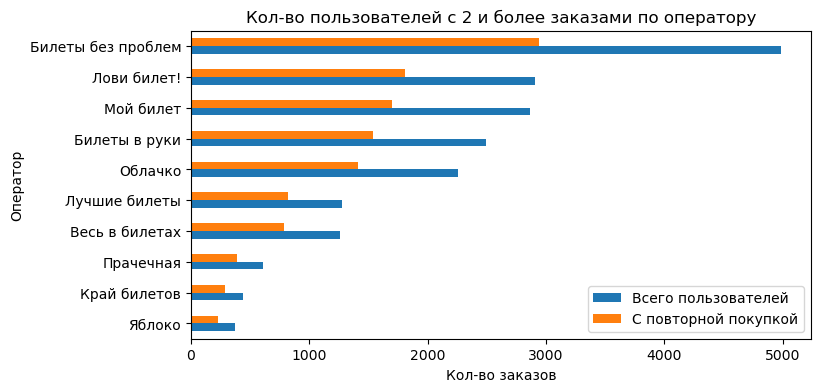

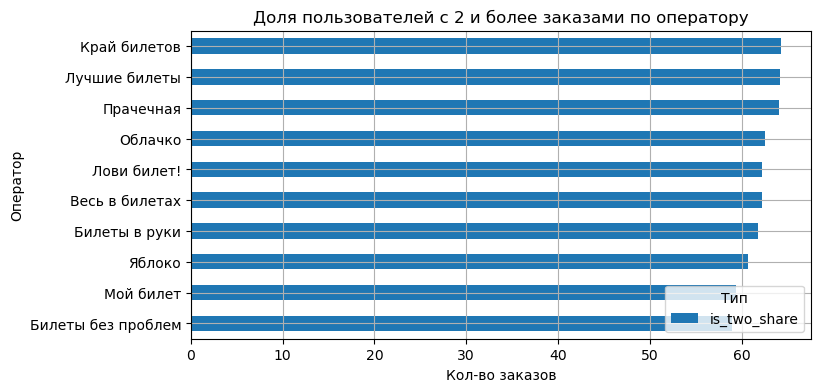

In [72]:
df_first_service_is_two[['service_first', 'users_count', 'is_two_count']].sort_values('users_count').plot(kind='barh',
                x='service_first', y=['users_count', 'is_two_count'],
                title=f'Кол-во пользователей с 2 и более заказами по оператору',
                legend=True,
                ylabel='Оператор',
                xlabel='Кол-во заказов',
                label=['Всего пользователей', 'С повторной покупкой'],
                rot=0,
                figsize=(8, 4))
df_first_service_is_two[['service_first', 'is_two_share']].sort_values('is_two_share').plot(kind='barh',
                title=f'Доля пользователей с 2 и более заказами по оператору',
                x='service_first',
                legend=True,
                ylabel='Оператор',
                xlabel='Кол-во заказов',
                rot=0,
                figsize=(8, 4))
plt.grid()
plt.legend(title='Тип', loc='lower right')

plt.show()

У всех сегментов примерно одинаковый процент повторной покупки, который варьируется в районе 60%.
Однако, можно отметить, что:
- "Край билетов" и "Лучшие билеты" чуть лучше (64%) удерживают пользователей;
- Пользователи из Светополянского округа в 68% случаев возвращаются для покупки;
- Театры - лидеры повторных покупок, на равне с *елками (может быть недостаточно данных)* - 65%

#### Задача 4.1.3. Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:
- Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Гипотеза 1 : Это действительно так, однакому разница совсем небольшая. 62,86% пользователей покупают билеты на спорт повторно, в то время как 60,75% пользователей покупают повторно билеты на концерт.

Гипотеза 2: Не подтверждена. В лидере по кол-ву пользователей (Каменевская область) 61.40% возвращаются. Однако, в Светополянский округ, где в 15 раз меньше людей процент возврата 67.96%

### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

#### Задача 4.2.1. Проследите связь между средней выручкой сервиса с заказа и повторными заказами.
- Постройте сравнительные гистограммы распределения средней выручки с билета ( avg_revenue_rub ):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы: 
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?


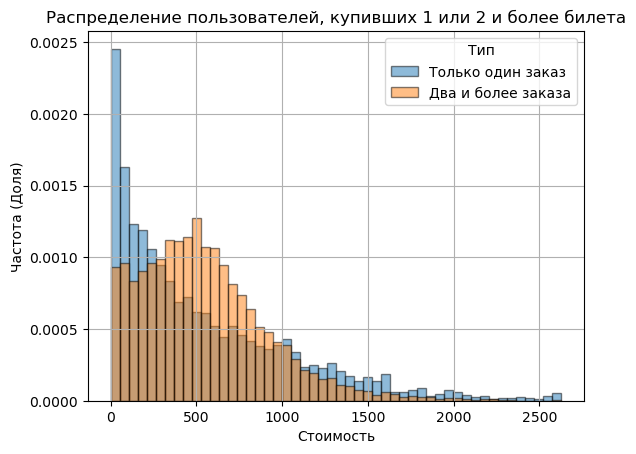

In [73]:
df_eda['avg_rev'][df_eda['is_two']==0].plot(
                kind='hist',
                bins=50,
                alpha=0.5,
                edgecolor='black',
                rot=0,
                density=True,
                label='Только один заказ'
)
df_eda['avg_rev'][df_eda['is_two']==1].plot(
                kind='hist',
                bins=50,
                alpha=0.5,
                edgecolor='black',
                rot=0,
                density=True,
                label='Два и более заказа'
)

plt.title('Распределение пользователей, купивших 1 или 2 и более билета')
plt.xlabel('Стоимость')
plt.ylabel('Частота (Доля)')
plt.legend(title='Тип')
# Добавляем сетку графика
plt.grid()

plt.show()

In [74]:
df_eda['avg_rev'][df_eda['is_two']==0].describe()

count    8363.000000
mean      545.774760
std       519.402522
min         0.000000
25%       133.055000
50%       378.870000
75%       830.975000
max      2628.420000
Name: avg_rev, dtype: float64

In [75]:
df_eda['avg_rev'][df_eda['is_two']==1].describe()

count    13259.000000
mean       545.070666
std        369.285424
min          0.000000
25%        271.682500
50%        496.543333
75%        745.630577
max       2628.420000
Name: avg_rev, dtype: float64

Ответ 1: Диапазон средних значений у обоих выборок одинаковый, в то время, как медианы отличаются более чем на 100 руб. Пользователи получившие билет бесплатно или по очень низкой цене (примерно до 250 руб.) реже возвращались за повторной покупкой. После этого порога, ситуация меняется в другую сторону, люди, кто покупает билеты по срденим ценам чаще других возвращаются за покупкой. После 1000 рублей ситуация меняется и вновь тех, кто покупает один раз больше.

Ответ 2: Различия между группами есть, можно предположить, что возвращабются за повторной покупкой пользователи, которые покупают билет по оптимальным ценам, копят баллы и постоянно пользуются сервисом. В то время как одноразовые покупки часто совершаются импульсно, либо из-за хороших цен (возможно бесплатных промокодов), либо выкупаются дорогие билеты.

#### Задача 4.2.2. Сравните распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

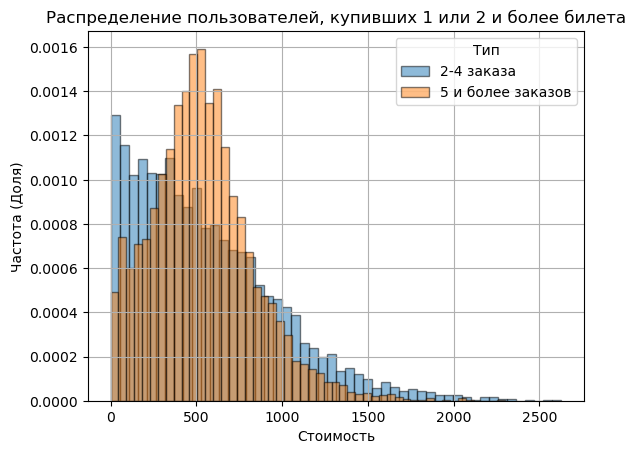

In [76]:
df_eda['avg_rev'][(df_eda['is_two']==1) & (df_eda['is_five']==0)].plot(
                kind='hist',
                bins=50,
                alpha=0.5,
                edgecolor='black',
                rot=0,
                density=True,
                label='2-4 заказа'
)
df_eda['avg_rev'][df_eda['is_five']==1].plot(
                kind='hist',
                bins=50,
                alpha=0.5,
                edgecolor='black',
                rot=0,
                density=True,
                label='5 и более заказов'
)

plt.title('Распределение пользователей, купивших 1 или 2 и более билета')
plt.xlabel('Стоимость')
plt.ylabel('Частота (Доля)')
plt.legend(title='Тип')
# Добавляем сетку графика
plt.grid()

plt.show()

In [77]:
df_eda['avg_rev'][(df_eda['is_two']==1) & (df_eda['is_five']==0)].describe()

count    7143.000000
mean      552.318953
std       420.136851
min         0.000000
25%       219.565000
50%       472.470000
75%       799.257500
max      2628.420000
Name: avg_rev, dtype: float64

In [78]:
df_eda['avg_rev'][df_eda['is_five']==1].describe()

count    6116.000000
mean      536.605246
std       298.957801
min         0.000000
25%       331.692137
50%       513.309000
75%       700.967911
max      2299.867500
Name: avg_rev, dtype: float64

Значенительной разницы в среднем арифметическом нету, однако медианные значений отличаются. 472 и 513 рублей.

#### Задача 4.2.3. Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.
- Изучите распределение пользователей по среднему количеству билетов в заказе ( avg_tickets_count ) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

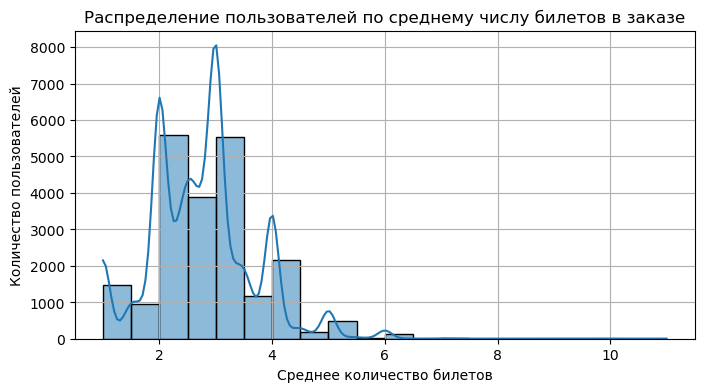

In [79]:
plt.figure(figsize=(8, 4))
sns.histplot(df_eda['avg_tickets'],
             bins=20,
             kde=True)

plt.title('Распределение пользователей по среднему числу билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()


In [80]:
# Создадим и сгруппируем по категориям 1-2, 2-3, 3-5, 5%
bins = [0, 2, 3, 5, float('inf')]
labels = ['1-2', '2-3', '3-5', '5+']

#copy, тк python выдает предупреждения.
df_eda = df_eda.copy()
df_eda['tickets_segment'] = pd.cut(df_eda['avg_tickets'], bins=bins, labels=labels, right=False)


In [81]:
df_segment = df_eda.groupby('tickets_segment').agg(
    users_count=('user_id', 'count'),
    repeat_count=('is_two', 'sum')
).reset_index()

df_segment['repeat_share'] = (df_segment['repeat_count'] / df_segment['users_count'] * 100).round(2)
df_segment


C:\Users\frezc\AppData\Local\Temp\ipykernel_20076\2876286099.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_segment = df_eda.groupby('tickets_segment').agg(


,tickets_segment,users_count,repeat_count,repeat_share
0,1-2,2410,1235,51.24
1,2-3,9487,6979,73.56
2,3-5,9064,4921,54.29
3,5+,661,124,18.76


Ответ 1: 
Пользователи расрпеделены по сегментам неравномерно. Основная часть часть сосредоточена в сегментах "2-3", "3-5" билетов. Примерно поровну. 9000-9500 пользователей. Меньше всего пользователей в сегменте 5+. Всего лишь 661 пользователь.

Ответ 2:
Замечено, что пользователи купившие 5 и более билетов, возвращаются сильно реже других. Всего лишь 19% пользователей вернулись за повторной покупкой.
В то время, как пользователи, купившие 2-3  билета возвращаются за повторной покупкой в 74% случаев.

### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки
Изучите временные параметры, связанные с первым заказом пользователей:
- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

In [82]:
df_eda.head()

,user_id,first_date,last_date,device_first,region_first,service_first,genre_first,total_orders,avg_rev,avg_tickets,avg_days_below,is_two,is_five,tickets_segment
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>,0,0,3-5
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,За билетом!,другое,2,774.010000,3.000000,75.0,1,0,3-5
2,000898990054619,2024-07-13,2024-10-23,mobile,Озернинский край,Билеты без проблем,стендап,3,767.213333,2.666667,51.0,1,0,2-3
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>,0,0,3-5
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,1-2


In [83]:
# группируем по дням недели и посчитаем кол-во пользователей
df_first_day = df_eda.groupby(df_eda['first_date'].dt.day_name()).agg(users_count=('user_id','count'))
df_first_day.reset_index()



,first_date,users_count
0,Friday,3256
1,Monday,2918
2,Saturday,3323
3,Sunday,2777
4,Thursday,3112
5,Tuesday,3175
6,Wednesday,3061


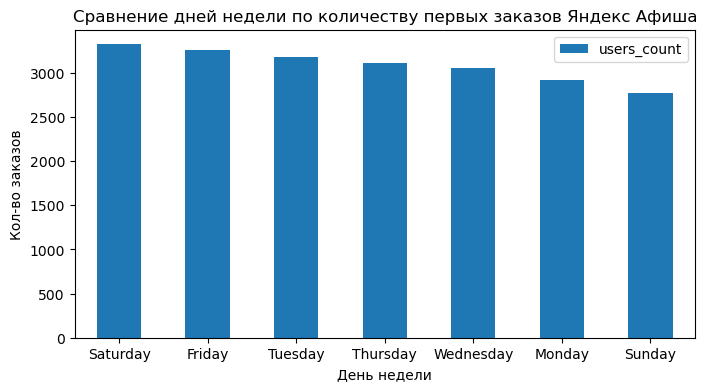

In [84]:
df_first_day.sort_values(by='users_count', ascending=False).plot(kind='bar',
                title=f'Сравнение дней недели по количеству первых заказов Яндекс Афиша',
                legend=True,
                ylabel='Кол-во заказов',
                xlabel='День недели',
                label=['Всего пользователей', 'С повторной покупкой'],
                rot=0,
                figsize=(8, 4))

plt.show()

На графике можно наблюдать, что большинство первых покупок сконцентрированно в субботу и пятницу, что обуславливается общепринятыми выходными.

In [85]:
# Посчитаем lifetime для каждого пользователя
df_lifetime = df_eda[['user_id','first_date','last_date']]
df_lifetime['lifetime']=(df_lifetime['last_date'] - df_lifetime['first_date']).dt.days
df_lifetime.sort_values(by='lifetime', ascending=False)

C:\Users\frezc\AppData\Local\Temp\ipykernel_20076\1672204657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lifetime['lifetime']=(df_lifetime['last_date'] - df_lifetime['first_date']).dt.days


,user_id,first_date,last_date,lifetime
14075,a5840eacaefcc8b,2024-06-01,2024-10-31,152
18040,d291124a4533927,2024-06-01,2024-10-31,152
8768,664495f30c32e5e,2024-06-01,2024-10-31,152
4281,3240834d0b5d360,2024-06-01,2024-10-31,152
19632,e5c01b7f050bee2,2024-06-01,2024-10-31,152
...,...,...,...,...
9671,715fbf4433540df,2024-08-15,2024-08-15,0
9681,718673b228373d6,2024-06-24,2024-06-24,0
9683,71905c5a4aa4811,2024-07-26,2024-07-26,0
9684,719217014352f7e,2024-10-18,2024-10-18,0


In [86]:
df_lifetime['lifetime'].describe()


count    21622.000000
mean        38.281935
std         51.597672
min          0.000000
25%          0.000000
50%          0.000000
75%         79.000000
max        152.000000
Name: lifetime, dtype: float64

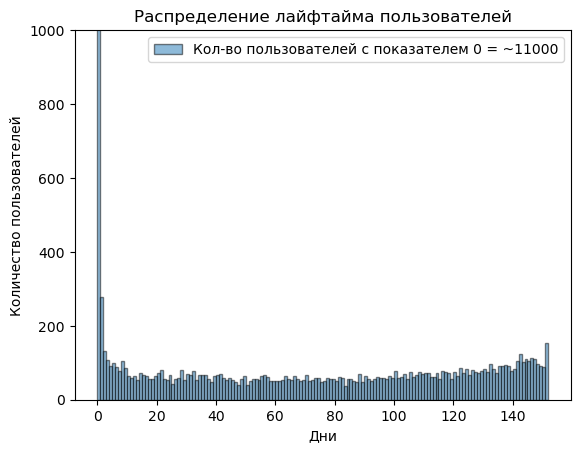

In [87]:
df_lifetime['lifetime'].plot(
                kind='hist',
                bins=152,
                alpha=0.5,
                edgecolor='black',
                rot=0,
                density=False,
                label='Кол-во пользователей с показателем 0 = ~11000'
            )

plt.title('Распределение лайфтайма пользователей')
plt.xlabel('Дни')
plt.legend()
plt.ylabel('Количество пользователей')
plt.ylim(0,1000) #ограничим для более детальной визуализации
plt.show()


- Большинство пользователей имеют lifetime=0 (~11000). График ограничен для более детальной визуализации.
- Длинный хвост распределения от 1 до 152 дней
- Медианное значние не равно среднему. Пользователей с коротким сроком жизни больше остальных.

In [88]:
# выведем пользователей с повтроными покупками
repeat_users = df_eda[df_eda['is_two']==1]
repeat_users['avg_days_below'].describe()


count      13259.0
mean     16.069313
std      22.330761
min            0.0
25%       1.333333
50%          8.375
75%      20.732143
max          148.0
Name: avg_days_below, dtype: Float64

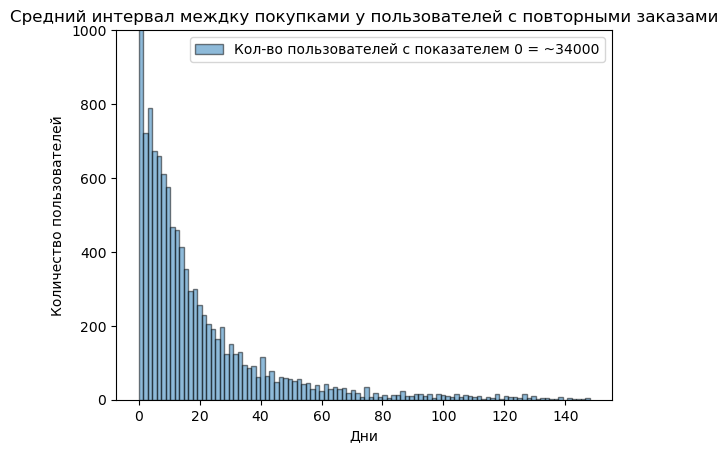

In [89]:
repeat_users['avg_days_below'].plot(
                kind='hist',
                bins=100,
                alpha=0.5,
                edgecolor='black',
                rot=0,
                density=False,
                label='Кол-во пользователей с показателем 0 = ~34000'
            )

plt.title('Средний интервал междку покупками у пользователей с повторными заказами')
plt.xlabel('Дни')
plt.legend()
plt.ylabel('Количество пользователей')
plt.ylim(0,1000) #ограничим для более детальной визуализации
plt.show()


средний интервал между покупками у пользователей с повторными заказами составялет ~16, в то время, как медианное значение равно 8. На графике видно, что есть много пользователей, которые совершают покупки в тот же или в ближайшие дни.

### Задача 4.3.1. Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

In [90]:
# группируем по дням недели и посчитаем кол-во пользователей
df_first_day = df_eda.groupby(df_eda['first_date'].dt.day_name()).agg(
    users_count=('user_id','count'),
    repeat_count=('is_two','sum'),
)
df_first_day['repeat_share']=round((df_first_day['repeat_count']/df_first_day['users_count'])*100, 2)
df_first_day.reset_index()

,first_date,users_count,repeat_count,repeat_share
0,Friday,3256,1946,59.77
1,Monday,2918,1838,62.99
2,Saturday,3323,2086,62.77
3,Sunday,2777,1668,60.06
4,Thursday,3112,1850,59.45
5,Tuesday,3175,1965,61.89
6,Wednesday,3061,1906,62.27


Ответ: 
Вероятность повторной покупки от дня недели не зависит.

### Задача 4.3.2. Изучите, как средний интервал между заказами влияет на удержание клиентов.
- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

In [91]:
days_orders = df_eda[['avg_days_below','is_two','is_five']][df_eda['is_two']==1]
days_orders

,avg_days_below,is_two,is_five
1,75.0,1,0
2,51.0,1,0
4,16.0,1,0
5,0.083333,1,1
6,0.0,1,0
...,...,...,...
21831,20.0,1,0
21832,26.0,1,0
21833,13.375,1,1
21834,74.0,1,0


In [92]:
days_orders.loc[
    (days_orders['is_two']==1) & 
    (days_orders['is_five']==0),
    'orders_group'
    ] = '2-4 заказа'

days_orders.loc[
    (days_orders['is_five']==1),
    'orders_group'
    ] = '5+ заказа'

In [93]:
days_orders

,avg_days_below,is_two,is_five,orders_group
1,75.0,1,0,2-4 заказа
2,51.0,1,0,2-4 заказа
4,16.0,1,0,2-4 заказа
5,0.083333,1,1,5+ заказа
6,0.0,1,0,2-4 заказа
...,...,...,...,...
21831,20.0,1,0,2-4 заказа
21832,26.0,1,0,2-4 заказа
21833,13.375,1,1,5+ заказа
21834,74.0,1,0,2-4 заказа


In [94]:
days_orders.groupby('orders_group').mean()

,avg_days_below,is_two,is_five
orders_group,,,
2-4 заказа,21.348161,1.0,0.0
5+ заказа,9.904038,1.0,1.0


Ответ: 
Средний интервал между заказами связан с вероятностью повторного заказа. У пользователей с 5 и более заказами, средний интервал между заказами не превышает 10 дней, в то врпмя, как у остальных пользователей средний интервал составляет 21 день. Можно предположить, что те, у кого %= заказов - постоянные пользоавтели сервиса, которые регулярно посещают мероприятия.

### Промежуточный вывод:
- Точки входа на платформу:
    - Мобильное устройство
    - Оператор "билет без проблем"
    - Вид мероприятия концерт
    - Каменевский регион.
- Лидеры по удерданию пользователей:
    - "Край билетов"
    - Светопольский окрйг
    - Театры
- Повторную покупку чаще делают пользователи из средней ценовой категории (~500 руб.)
- БОльшая часть пользователей покупает от 2 до 5 билетов
- Средний интервал между заказами связан с вероятностью повторного заказа

### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.
#### Задача 4.4.1: Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов ( total_orders ). При необходимости используйте параметр interval_cols для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в total_orders. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю total_orders, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов? 

In [95]:
# Создадим и сгруппируем по категориям 1-2, 2-3, 3-5, 5%
bins_orders = [0, 1, 4, float('inf')]
labels_orders = ['1', '2-4', '5+']

In [96]:
df_eda['order_segments'] = pd.cut(df_eda['total_orders'], bins=bins_orders, labels=labels_orders, right=True)

In [97]:
df_eda.columns

Index(['user_id', 'first_date', 'last_date', 'device_first', 'region_first',
       'service_first', 'genre_first', 'total_orders', 'avg_rev',
       'avg_tickets', 'avg_days_below', 'is_two', 'is_five', 'tickets_segment',
       'order_segments'],
      dtype='object')

In [98]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df_eda[['first_date', 'last_date', 'device_first', 'region_first',
       'service_first', 'genre_first', 'total_orders', 'avg_rev',
       'avg_tickets', 'avg_days_below', 'is_two', 'is_five', 'tickets_segment',
       'order_segments']].phik_matrix()

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной rating')
correlation_matrix.loc[correlation_matrix.index != 'order_segments'][['order_segments']].sort_values(by='order_segments', ascending=False)

interval columns not set, guessing: ['total_orders', 'avg_rev', 'avg_tickets', 'avg_days_below', 'is_two', 'is_five']
Корреляционная матрица с коэффициентом phi_k для переменной rating


,order_segments
is_two,1.000000
is_five,1.000000
last_date,0.607123
first_date,0.577723
total_orders,0.488036
avg_days_below,0.390944
avg_tickets,0.383043
avg_rev,0.325259
tickets_segment,0.226003
region_first,0.091152


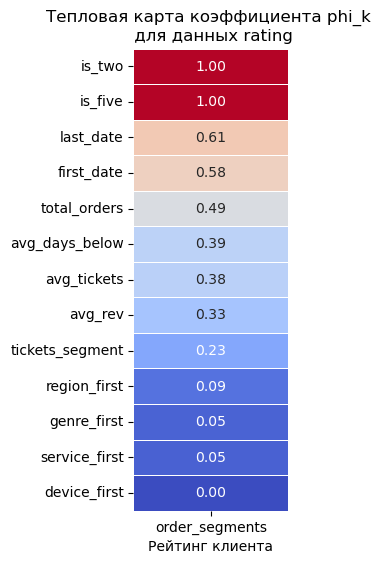

In [99]:
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака rating с другими признаками клиента
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'order_segments'][['order_segments']].sort_values(by='order_segments', ascending=False)
sns.heatmap(data_heatmap,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=False #
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных rating')
plt.xlabel('Рейтинг клиента')

# Выводим график
plt.show()

Наиболее сильная связь с сегментом по числу заказов наблюдается у временных характеристик — даты первого и последнего заказа. Это указывает на влияние лайфтайма пользователя на общее количество покупок.\
Поведенческие показатели (средний чек, количество билетов, средний интервал между покупками) демонстрируют умеренную положительную корреляцию, что может говорить о большей вовлечённости пользователей с повторными заказами.\
При этом категориальные признаки первого заказа (тип устройства, жанр мероприятия, билетный оператор, регион) практически не связаны с вероятностью повторных покупок.

Поскольку сегментация пользователей основана на количестве заказов, корреляции с производными признаками `is_two`, `is_five`, `total_orders` не интерпретируются как независимые факторы влияния.

# Общий вывод и рекомендации

## 1. Данные и подготовка

В работе использовались данные сервиса Яндекс Афиша о заказах пользователей и характеристиках мероприятий. В анализ были включены только заказы, оформленные с **мобильных и десктопных устройств**, заказы на фильмы были исключены из-за недостаточного объёма данных.

Выручка представлена в рублях и тенге, поэтому все значения были **приведены к рублям** с использованием дневного курса валют за 2024 год. Для анализа поведения пользователей были рассчитаны дополнительные показатели: количество дней с момента предыдущей покупки, средний интервал между покупками, среднее число билетов и средняя выручка на заказ. Также были изучены распределения показателей и учтены выбросы.

---

## 2. Основные результаты анализа

В выборке преобладают пользователи с **одним заказом**; доля пользователей с 2–4 заказами значительно меньше, а сегмент с 5 и более заказами — самый малочисленный, но наиболее ценный с точки зрения удержания.

Анализ показал, что **категориальные характеристики первого заказа** (тип устройства, билетный оператор, регион и жанр мероприятия) **слабо связаны** с вероятностью повторных покупок.

В то же время пользователи с **большим средним числом билетов в заказе** и **более высокой средней выручкой** чаще совершают повторные покупки, что указывает на более высокую вовлечённость таких пользователей.

Среди временных характеристик наибольшее значение имеют **интервалы между покупками** и **лайфтайм пользователя**: пользователи с меньшими интервалами и более длительной историей активности чаще совершают повторные заказы. День недели первого заказа оказывает незначительное влияние.

Корреляционный анализ подтвердил, что число заказов сильнее связано с временными и поведенческими показателями, чем с параметрами первого заказа.

---

## 3. Рекомендации

1. Сфокусироваться на **стимулировании повторной покупки** в короткий срок после первого заказа.
2. Уделить особое внимание пользователям с **2–4 заказами**, так как этот сегмент имеет потенциал перехода в группу наиболее лояльных клиентов.
3. Использовать **поведенческие метрики** (интервалы между покупками, среднее число билетов, средний чек) для персонализации коммуникаций.
4. Не делать акцент на характеристиках первого заказа при построении стратегий удержания, так как их влияние минимально.
5. Развивать сценарии повторного вовлечения пользователей на основе времени с последней покупки.

---


In [100]:
import sys
sys.executable

'C:\\ProgramData\\anaconda3\\python.exe'